Рассматривается задача обучения без учителя (кластеризация) и применение к ней различных методов	
- +2 Применен метод k средних
- +4 Применены иерархические методы
- +2 Подсчитаны метрики для задачи кластеризации
- +2 Визуализированы результаты кластеризации

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
)
from sklearn.decomposition import PCA
from kneed import KneeLocator

import warnings

## init

In [ ]:
warnings.filterwarnings("ignore")

SEED = 42

In [50]:
data = pd.read_csv("../data/health_lifestyle_dataset.csv")

## K-Means Clustering

In [51]:
data

,id,age,gender,bmi,daily_steps,sleep_hours,water_intake_l,calories_consumed,smoker,alcohol,resting_hr,systolic_bp,diastolic_bp,cholesterol,family_history,disease_risk
0,1,56,Male,20.5,4198,3.9,3.4,1602,0,0,97,161,111,240,0,0
1,2,69,Female,33.3,14359,9.0,4.7,2346,0,1,68,116,65,207,0,0
2,3,46,Male,31.6,1817,6.6,4.2,1643,0,1,90,123,99,296,0,0
3,4,32,Female,38.2,15772,3.6,2.0,2460,0,0,71,165,95,175,0,0
4,5,60,Female,33.6,6037,3.8,4.0,3756,0,1,98,139,61,294,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99996,53,Male,33.1,4726,3.9,2.0,3118,0,1,56,105,76,282,0,0
99996,99997,22,Male,35.1,11554,4.5,3.1,1967,0,0,51,149,77,192,0,0
99997,99998,37,Male,18.9,3924,3.8,1.0,2328,0,0,69,92,117,218,0,0
99998,99999,72,Female,27.8,16110,5.6,0.8,3093,0,0,93,164,72,188,0,0


In [52]:
data.isnull().sum()

id                   0
age                  0
gender               0
bmi                  0
daily_steps          0
sleep_hours          0
water_intake_l       0
calories_consumed    0
smoker               0
alcohol              0
resting_hr           0
systolic_bp          0
diastolic_bp         0
cholesterol          0
family_history       0
disease_risk         0
dtype: int64

In [53]:
df = data.copy()

cols_to_drop = ["id", "disease_risk"]
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(
    include=["object", "category", "bool"]
).columns.tolist()

print("num:", num_cols)
print("cat:", cat_cols)

num: ['age', 'bmi', 'daily_steps', 'sleep_hours', 'water_intake_l', 'calories_consumed', 'smoker', 'alcohol', 'resting_hr', 'systolic_bp', 'diastolic_bp', 'cholesterol', 'family_history']
cat: ['gender']


### Encoder and normalization data

In [ ]:
num_pipe = Pipeline(
    steps=[
        # ("imputer", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler()),
    ]
)

cat_pipe = Pipeline(
    steps=[
        # ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop",
)

X_pre = preprocess.fit_transform(df)

### Search for the best k-values

In [ ]:
k_values = list(range(2, 6))
results = []

models = {}
for k in k_values:
    km = KMeans(n_clusters=k, random_state=SEED)
    km.fit(X_pre)
    labels = km.labels_

    sil = silhouette_score(X_pre, labels)
    cal = calinski_harabasz_score(X_pre, labels)
    dav = davies_bouldin_score(X_pre, labels)

    results.append(
        {
            "k": k,
            "wcss": km.inertia_,
            "silhouette": sil,
            "cal": cal,
            "dav": dav,
        }
    )
    models[k] = km

scores_df = pd.DataFrame(results)

display(scores_df)

,k,wcss,silhouette,cal,dav
0,2,387988.232934,0.114045,12887.235089,2.761641
1,3,375487.821138,0.076917,8322.597170,3.375634
2,4,362809.655404,0.064288,6906.985138,3.761705
3,5,355256.307035,0.058896,5821.862679,3.533364


### Visualization of evaluation score

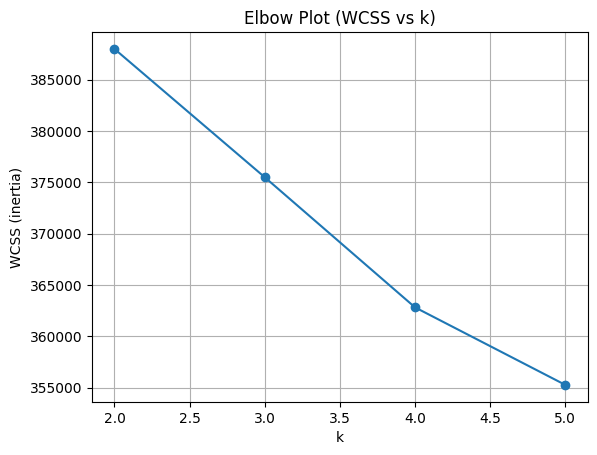

In [56]:
plt.figure()
plt.plot(scores_df["k"], scores_df["wcss"], marker="o")
plt.title("Elbow Plot (WCSS vs k)")
plt.xlabel("k")
plt.ylabel("WCSS (inertia)")
plt.grid(True)
plt.show()

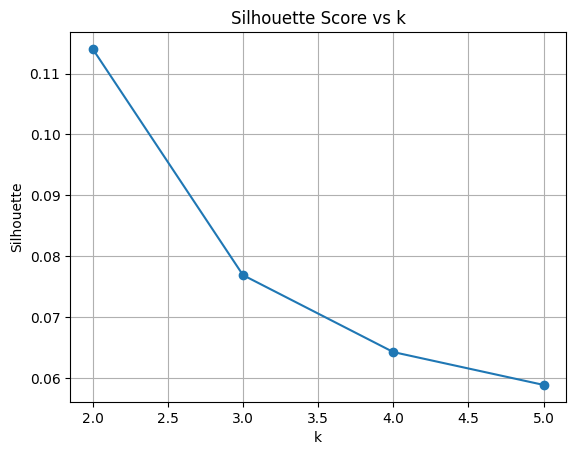

In [57]:
plt.figure()
plt.plot(scores_df["k"], scores_df["silhouette"], marker="o")
plt.title("Silhouette Score vs k")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.grid(True)
plt.show()

### Detail for each cluster

In [58]:
best_model = models[2]
labels = best_model.labels_

df_with_cluster = df.copy()
df_with_cluster["cluster"] = labels

print(df_with_cluster["cluster"].value_counts().sort_index())

cluster
0    50132
1    49868
Name: count, dtype: int64


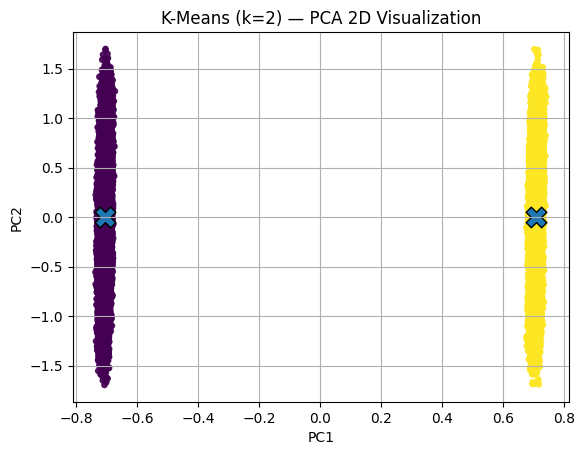

In [59]:
pca = PCA(n_components=2, random_state=SEED)
X_pca = pca.fit_transform(X_pre)

centers_pca = pca.transform(best_model.cluster_centers_)

plt.figure()
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=labels,
    s=14,
    alpha=0.9,
)
plt.scatter(
    centers_pca[:, 0],
    centers_pca[:, 1],
    marker="X",
    s=220,
    edgecolors="k",
)
plt.title(f"K-Means (k=2) — PCA 2D Visualization")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

## Hierarchical Clustering

### Sampling Data

In [60]:
data = data.sample(n=10_000)

### Drop Target and check column typw

In [ ]:
df = data.copy()

cols_to_drop = ["id", "disease_risk"]
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(
    include=["object", "category", "bool"]
).columns.tolist()

print("Numerical:", num_cols)
print("Categorical:", cat_cols)

Numerical: ['age', 'bmi', 'daily_steps', 'sleep_hours', 'water_intake_l', 'calories_consumed', 'smoker', 'alcohol', 'resting_hr', 'systolic_bp', 'diastolic_bp', 'cholesterol', 'family_history']
Categorical: ['gender']


### Encoder categorical and normalization data

In [62]:
num_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler()),
    ]
)

cat_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop",
)

X_pre = preprocess.fit_transform(df)
display(X_pre.shape)
display(X_pre)

(10000, 15)

array([[-0.35483871, -0.58181818,  0.9045197 , ...,  0.        ,
         1.        ,  0.        ],
       [-0.61290323, -0.01818182,  0.54947951, ...,  0.        ,
         0.        ,  1.        ],
       [-0.32258065,  0.85454545, -0.10388721, ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [-0.41935484, -0.54545455, -0.24071683, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.64516129, -0.39090909,  0.26432995, ...,  0.        ,
         0.        ,  1.        ],
       [-0.12903226, -0.31818182,  0.7430228 , ...,  0.        ,
         0.        ,  1.        ]], shape=(10000, 15))

### Search for the best k-values

In [63]:
def within_sse(X, labels):
    sse = 0.0
    for c in np.unique(labels):
        Xi = X[labels == c]
        mu = Xi.mean(axis=0)
        sse += ((Xi - mu) ** 2).sum()
    return float(sse)


def run_hc_sweep(X, k_values, linkages=("ward", "average", "complete")):
    rows, models = [], {}
    for link in linkages:
        for k in k_values:
            if link == "ward":
                model = AgglomerativeClustering(n_clusters=k, linkage="ward")
            else:
                model = AgglomerativeClustering(
                    n_clusters=k, linkage=link, metric="euclidean"
                )
            labels = model.fit_predict(X)
            sil = silhouette_score(X, labels, metric="euclidean")
            dbi = davies_bouldin_score(X, labels)
            ch = calinski_harabasz_score(X, labels)
            sse = within_sse(X, labels)
            rows.append(
                {
                    "linkage": link,
                    "k": k,
                    "silhouette": sil,
                    "dbi": dbi,
                    "ch": ch,
                    "sse": sse,
                }
            )
            models[(link, k)] = model
    return pd.DataFrame(rows), models


k_values = list(range(2, 22))
hc_scores, hc_models = run_hc_sweep(X_pre, k_values)


def k_by_kneedle(
    df_link, x_col="k", y_col="sse", curve="convex", direction="decreasing"
):
    df_link = df_link.sort_values(x_col)
    ks = df_link[x_col].values
    ys = df_link[y_col].values
    kl = KneeLocator(ks, ys, curve=curve, direction=direction)
    if kl.knee is None:
        return None
    return int(kl.knee)


best_k = {}
for link in hc_scores["linkage"].unique():
    sub = hc_scores[hc_scores["linkage"] == link]

    k_sse = k_by_kneedle(
        sub, y_col="sse", curve="convex", direction="decreasing"
    )

    k_dbi = k_by_kneedle(
        sub, y_col="dbi", curve="convex", direction="decreasing"
    )

    if k_sse is None and k_dbi is None:
        k_alt = int(sub.loc[sub["dbi"].idxmin(), "k"])
    else:
        candidates = [k for k in [k_sse, k_dbi] if k is not None]
        k_alt = (
            int(np.median(candidates))
            if candidates
            else int(sub.loc[sub["dbi"].idxmin(), "k"])
        )

    best_k[link] = {"k_sse": k_sse, "k_dbi": k_dbi, "k_final": k_alt}

best_k

{'ward': {'k_sse': 10, 'k_dbi': 2, 'k_final': 6},
 'average': {'k_sse': 4, 'k_dbi': 3, 'k_final': 3},
 'complete': {'k_sse': 9, 'k_dbi': 2, 'k_final': 5}}

In [64]:
picks = [("ward", 5), ("average", 2), ("complete", 9)]
rows = []
for link, k in picks:
    mdl = hc_models[(link, k)]
    labels = mdl.fit_predict(X_pre)
    cnts = np.bincount(labels)
    rows.append(
        {
            "linkage": link,
            "k": k,
            "sizes": cnts.tolist(),
            "silhouette": silhouette_score(X_pre, labels),
            "dbi": davies_bouldin_score(X_pre, labels),
            "ch": calinski_harabasz_score(X_pre, labels),
        }
    )
pd.DataFrame(rows)

,linkage,k,sizes,silhouette,dbi,ch
0,ward,5,"[2169, 2756, 2344, 1558, 1173]",0.018472,5.701941,420.492987
1,average,2,"[4, 9996]",0.128219,1.748947,4.092826
2,complete,9,"[814, 1741, 2248, 1748, 980, 532, 533, 855, 549]",-0.007979,4.964403,212.540336


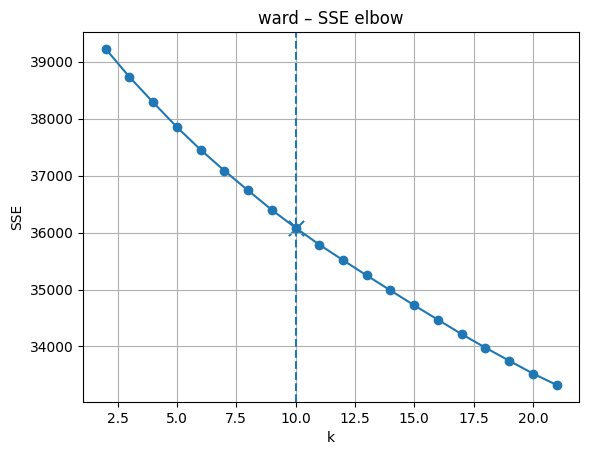

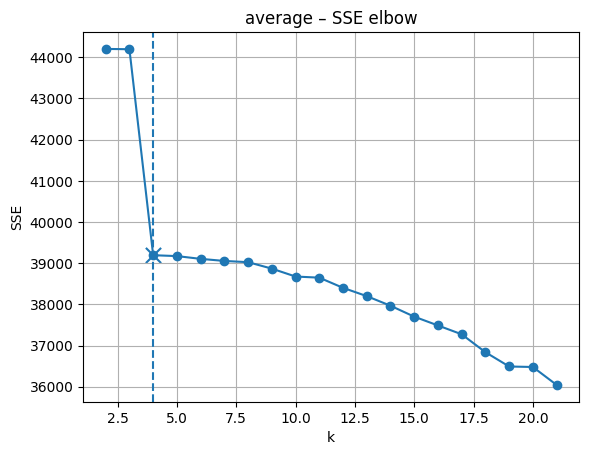

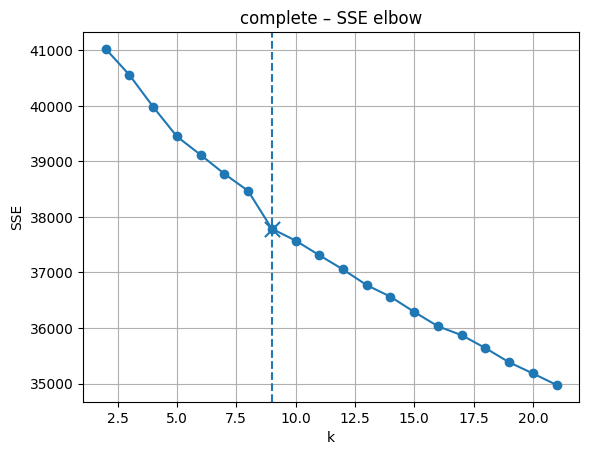

In [65]:
def plot_elbow(df_link, metric="sse", title=None):
    df_link = df_link.sort_values("k")
    ks, ys = df_link["k"].values, df_link[metric].values
    kl = KneeLocator(ks, ys, curve="convex", direction="decreasing")
    plt.figure()
    plt.plot(ks, ys, marker="o")
    if kl.knee is not None:
        plt.axvline(kl.knee, linestyle="--")
        plt.scatter(
            [kl.knee],
            [df_link[df_link["k"] == kl.knee][metric].values[0]],
            s=120,
            marker="x",
        )
    plt.xlabel("k")
    plt.ylabel(metric.upper())
    plt.title(title or f"Elbow on {metric.upper()}")
    plt.grid(True)
    plt.show()


for link in hc_scores["linkage"].unique():
    plot_elbow(
        hc_scores[hc_scores["linkage"] == link],
        metric="sse",
        title=f"{link} – SSE elbow",
    )

### Detail of cluster

In [66]:
best_link = "average"
best_k = 2

best_model = hc_models[(best_link, best_k)]
labels = best_model.fit_predict(X_pre)

df_hc = df.copy()
df_hc["cluster"] = labels

print(df_hc["cluster"].value_counts().sort_index())

cluster
0       4
1    9996
Name: count, dtype: int64


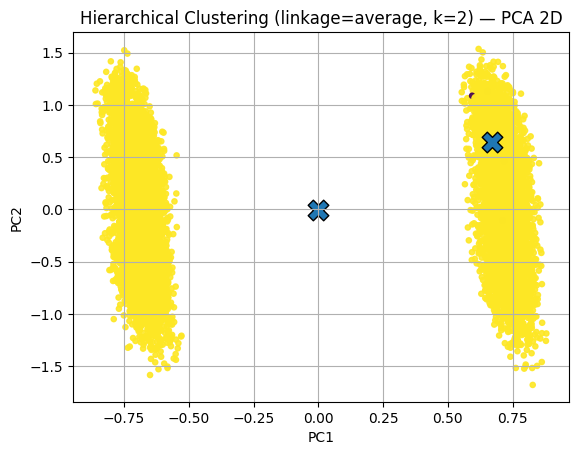

,age,bmi,daily_steps,sleep_hours,water_intake_l,calories_consumed,smoker,alcohol,resting_hr,systolic_bp,diastolic_bp,cholesterol,family_history
cluster,,,,,,,,,,,,,
0,24.50,24.05,2383.0,5.48,3.95,1447.00,0.5,0.25,76.00,112.00,63.5,198.75,0.75
1,48.67,29.08,10480.5,6.49,2.77,2596.42,0.2,0.30,74.36,134.19,89.7,223.68,0.30


In [67]:
# PCA 2D
pca = PCA(n_components=2, random_state=SEED)
X_pca = pca.fit_transform(X_pre)

centers = np.vstack(
    [X_pre[labels == c].mean(axis=0) for c in sorted(np.unique(labels))]
)
centers_pca = pca.transform(centers)

plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=14, alpha=0.9)
plt.scatter(
    centers_pca[:, 0], centers_pca[:, 1], marker="X", s=220, edgecolors="k"
)
plt.title(
    f"Hierarchical Clustering (linkage={best_link}, k={best_k}) — PCA 2D"
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

profile = df_hc.groupby("cluster").mean(numeric_only=True).round(2)
display(profile)

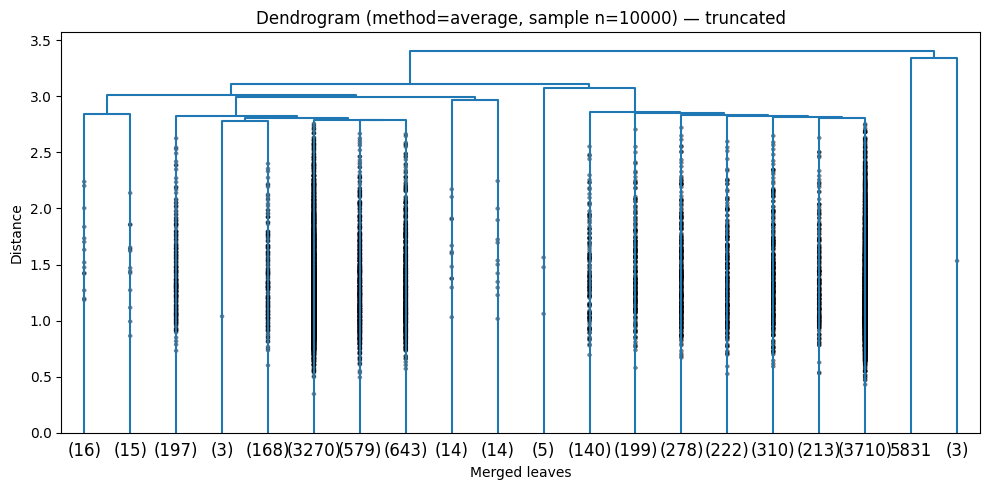

In [68]:
rng = np.random.RandomState(SEED)
n = X_pre.shape[0]
take = min(10_000, n)
idx = rng.choice(n, size=take, replace=False)
X_small = X_pre[idx]

# linkage method (best link)
method = best_link
Z = sch.linkage(X_small, method=method)  # default using Euclidean

plt.figure(figsize=(10, 5))
sch.dendrogram(
    Z, truncate_mode="lastp", p=20, show_leaf_counts=True, show_contracted=True
)
plt.title(f"Dendrogram (method={method}, sample n={take}) — truncated")
plt.xlabel("Merged leaves")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()